# Installs & Imports

In [1]:
!python --version # requires 3.8+

Python 3.8.0


In [2]:
!pip install -q wget chess seaborn numpy pandas

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
from pprint import pprint
%matplotlib auto

Using matplotlib backend: agg


# Classes & Functions

## Utilities

In [4]:
import time
import io
import base64

def sanitize_url(url):
    return Path(url).name.translate(dict.fromkeys(map(ord, '?='), '_'))

def round_nearest(x, n):
    return np.round(np.array(x) / n).astype(int) * n

def time_profile(fn):
    def new_fn(*args, **kwargs):
        start_t = time.time()
        ret = fn(*args, **kwargs)
        end_t = time.time()
        print(f'{fn.__name__} took {end_t - start_t:.2f}s')
        return ret
    return new_fn

def encode_image(img):
    buffer = io.BytesIO()
    img.savefig(buffer,  format='png')
    buffer.seek(0)
    encoded = base64.b64encode(buffer.read())
    return encoded.decode("utf-8").replace("\n", "")

## Data

In [5]:
import wget, bz2

def download(url, filename, overwrite=False):
    
    if '.pgn' not in filename:
        filename += '.pgn'
        pgn_filename = filename
    else:
        if not filename.endswith('.pgn'):
            idx = filename.find('.pgn') + 4
            pgn_filename = filename[:idx]
        else:
            pgn_filename = filename
            
    filename = Path(filename)
    if not filename.exists() or overwrite:
        print(f'Downloading {str(filename)} from {url}')
        filename = wget.download(str(url), str(filename))
        if filename.endswith('.bz2'):
            filename = bunzip(filename)
    else:
        print(f'{str(filename)} already exists. Pass in `overwrite=True` to overwrite it.')
        
    return pgn_filename

def bunzip(filename):
    zipped_filename = Path(filename)
    unzipped_filename = zipped_filename.with_suffix('')
    with open(unzipped_filename, 'wb') as f_out:
        with bz2.open(zipped_filename, 'rb') as f_in:
            f_out.write(f_in.read())
            print(f"Wrote {str(unzipped_filename)}")
            return unzipped_filename

In [6]:
#URL = 'https://lichess.org/games/export/seaghost27?max=100'
#URL = 'https://lichess.org/games/export/DrNykterstein?max=7000'
#URL = 'https://database.lichess.org/standard/lichess_db_standard_rated_2015-02.pgn.bz2'
URL = None
FILENAME = 'chess365_d35.pgn'

if URL:    
    filename = sanitize_url(URL)
    pgn_filename = download(URL, filename)
    
else:
    pgn_filename = FILENAME
    
print(pgn_filename)

chess365_d35.pgn


## Trie

In [7]:
import chess
from chess import pgn

In [48]:
def get_avg_elo(game):
    white_elo = game.headers.get('WhiteElo', '')
    black_elo = game.headers.get('BlackElo', '')
    if white_elo and black_elo and \
        not white_elo.endswith('?') and not black_elo.endswith('?'):
        
        avg_elo = (int(white_elo) + int(black_elo)) / 2
        return avg_elo
    elif white_elo and not white_elo.endswith('?'):
        return int(white_elo)
    elif black_elo and not black_elo.endswith('?'):
        return int(black_elo)
    else:
        return None

def get_moves(game):
    return [move.san() for move in game.mainline()]

def get_board_for_moves(moves):
    g = pgn.Game()
    for move in moves:
        new_move = g.end().board().push_san(move)
        g.end().add_main_variation(new_move)
        g = g.next()
    return g.board()

def get_moves_generator(game):
    for move in game.mainline():
        yield move.san()

def games_generator_from_file(filename,
                              max_games=None,
                              sample=1.0,
                              print_every=500):
    
    pgn_file = open(filename, encoding='ISO-8859-1')
    count = 0
    game = pgn.read_game(pgn_file)
    while game:
        if np.random.random() < sample:
            game_dict = dict(game.headers)
            game_dict['moves'] = get_moves(game)
            if (date := game_dict.get('UTCDate', None)) or (date := game_dict.get('Date', None)):
                year, month, day = date.split('.')
                game_dict['year'] = int(year) if '?' not in year else None
                game_dict['month'] = int(month) if '?' not in month else 0
                game_dict['day'] = int(day) if '?' not in day else 0
            game_dict['avg_elo'] = get_avg_elo(game)
            yield game_dict
            
            if (count % print_every) == 0:
                print(count)
            count += 1

            if max_games and count >= max_games:
                break
        
        game = pgn.read_game(pgn_file)

def get_move_to_games_mapping(trie, elo_min=0, elo_max=float('inf')):
    move_to_games = {}
    
    for move, sub_trie in trie.items():
        games = list(get_leaves(sub_trie))
        move_to_games[move] = games
        
    return move_to_games

def get_FEN_to_games(games):
    return {get_board_for_moves(game['moves']).fen(): game for game in games}

def build_move_df(trie, **kwargs):
    data = []
    move_to_games = get_move_to_games_mapping(trie, *kwargs)
    for move, games in move_to_games.items():
        for game in games:
            game = game.copy()
            game['move'] = move
            data.append(game)

    move_df = pd.DataFrame(data)
    return move_df

def get_elo_to_move_mapping(trie, bin_width=200):
    elo_to_move = defaultdict(list)

    for move, sub_trie in trie.items():
        for game in get_leaves(sub_trie):
            elo = game['avg_elo']
            rounded_elo = round_nearest(elo, bin_width)
            elo_to_move[rounded_elo].append(move)
            
    return elo_to_move

In [108]:
@time_profile
def make_game_trie(games, root=None):
    root = root or dict()
    for game in games:
        current_dict = root
        for move in game['moves']:
            current_dict = current_dict.setdefault(move, {})
        if None not in current_dict:
            current_dict[None] = []
        current_dict[None].append(game)
    return root

def in_trie(trie, moves):
    current_dict = trie
    for move in moves:
        if move not in current_dict:
            return False
        current_dict = current_dict[move]
    return True

def get_sub_trie(trie, moves):
    current_dict = trie
    for move in moves:
        if move not in current_dict:
            return None
        current_dict = current_dict[move]
    return current_dict

def count_trie(trie):
    count = 0
    for move, sub_trie in trie.items():
        if not isinstance(sub_trie, dict):
            leaves = sub_trie  # leaves are games
            count += len(leaves)
        else:
            count += count_trie(sub_trie)
    return count

def get_leaves(trie):
    leaves = []
    if isinstance(trie, list):
        for game in trie:
            yield game
    elif isinstance(trie, dict):
        for move, sub_trie in trie.items():
            for game in get_leaves(sub_trie):
                yield game

def filter_games(games,
                 white=None,
                 black=None,
                 min_elo=0,
                 max_elo=4000,
                 require_elo=False,
                 moves=None,
                 white_moves=None,
                 black_moves=None,
                 time_control=None):
    filtered = []
    for game in games:
        valid = True
        if white and game['White'] != white:
            valid = False
        elif black and game['Black'] != black:
            valid = False
        elif require_elo and not (min_elo < int(game['WhiteElo']) < max_elo):
            valid = False
        elif require_elo and not (min_elo < int(game['BlackElo']) < max_elo):
            valid = False
        elif moves and moves != game['moves'][:len(moves)]:
            valid = False
        elif white_moves and white_moves.intersection(set(game['moves'][::2])) != white_moves:
            valid = False
        elif black_moves and black_moves.intersection(set(game['moves'][1::2])) != black_moves:
            valid = False
        elif time_control and game['TimeControl'] != time_control:
            valid = False
        if valid:
            filtered.append(game)
    return filtered

def filter_trie(trie, **kwargs):
    new_trie = {}
    
    for move, sub_trie in trie.items():
        if move == None:
            new_trie[None] = filter_games(sub_trie, **kwargs)
        else:
            new_trie[move] = filter_trie(sub_trie, **kwargs)
    return new_trie

In [102]:
MAX_GAMES = 1000

games_gen = games_generator_from_file(pgn_filename, max_games=MAX_GAMES, sample=0.1, print_every=100)
trie = make_game_trie(games_gen)
print(count_trie(trie))

0
100
200


KeyboardInterrupt: 

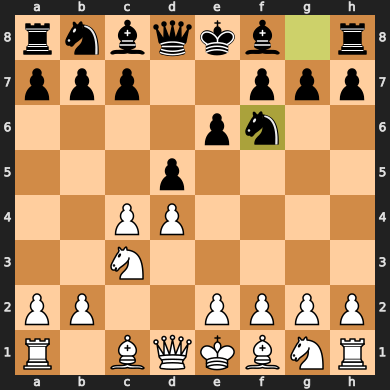

In [11]:
#LINE = ['e4', 'c5', 'Nf3', 'Nc6', 'd4', 'cxd4', 'Nxd4', ]  # open sicilian
LINE = ['d4', 'd5', 'c4', 'e6', 'Nc3', 'Nf6']  #
WHITE = None
BLACK = None

(BOARD := get_board_for_moves(LINE))

In [53]:
dir(BOARD)

['__annotations__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algebraic',
 '_algebraic_and_push',
 '_algebraic_without_suffix',
 '_attacked_for_king',
 '_attackers_mask',
 '_board_state',
 '_clear_board',
 '_ep_skewered',
 '_epd_operations',
 '_from_chess960',
 '_generate_evasions',
 '_is_halfmoves',
 '_is_safe',
 '_parse_epd_ops',
 '_push_capture',
 '_reduces_castling_rights',
 '_remove_piece_at',
 '_repr_svg_',
 '_reset_board',
 '_set_board_fen',
 '_set_castling_fen',
 '_set_chess960_pos',
 '_set_piece_at',
 '_set_piece_map',
 '_slider_blockers',
 '_stack',
 '_to_chess960',
 '_transposition_key',
 '_valid_ep_square',
 'aliases',


In [12]:
filtered_trie = filter_trie(trie,
                            moves=LINE,
                            white=WHITE,
                            black=BLACK)

line_trie = get_sub_trie(filtered_trie, LINE)
move_df = build_move_df(line_trie)
print(len(move_df))

677


## Statistics

In [13]:
def get_elo_move_count_df(move_df, bin_width=400):
    move_df = move_df.copy()
    move_df['avg_elo'] = round_nearest(move_df['avg_elo'], bin_width)
    group_df = move_df.groupby(['move', 'avg_elo']).size().reset_index().rename(columns={0: 'count'})
    return pd.crosstab(group_df.avg_elo, group_df.move, group_df['count'], aggfunc=sum).fillna(0)

def get_year_move_count_df(move_df, bin_width=1):
    move_df = move_df.copy()
    move_df['year_month'] = round_nearest(move_df['year'].values + (move_df['month'].values / 12).round(1), bin_width)
    group_df = move_df.groupby(['year_month', 'move']).size().reset_index().rename(columns={0: 'count'})
    return pd.crosstab(group_df.year_month, group_df.move, group_df['count'], aggfunc=sum).fillna(0)

def get_count_df(move_df, by=None, bin_width=10, map_fn=None):
    move_df = move_df.copy()
    if map_fn:
        move_df[by] = map_fn(move_df)
    move_df[by] = round_nearest(move_df[by], bin_width)
    group_df = move_df.groupby([by, 'move']).size().reset_index().rename(columns={0: 'count'})
    return pd.crosstab(group_df[by], group_df['move'], group_df['count'], aggfunc=sum).fillna(0)

def normalize(d, target=1.0):
    raw = sum(d.values())
    factor = target / raw
    return {key:value*factor for key,value in d.items()}

In [14]:
get_count_df(move_df,
             by='year',
             bin_width=1,
             map_fn=lambda df: round_nearest(df['year'] + (df['month']/12).round(1), 1))

move,Bf4,Bg5,Nf3,a3,cxd5,e3,f3,f4,g3
year,,,,,,,,,
2000,4.0,78.0,17.0,1.0,37.0,5.0,0.0,1.0,0.0
2001,4.0,109.0,35.0,0.0,46.0,3.0,1.0,0.0,1.0
2002,1.0,89.0,25.0,1.0,41.0,4.0,0.0,0.0,0.0
2003,1.0,42.0,22.0,0.0,37.0,2.0,0.0,0.0,0.0
2004,1.0,32.0,11.0,1.0,22.0,2.0,0.0,0.0,0.0


In [15]:
get_year_move_count_df(move_df)

move,Bf4,Bg5,Nf3,a3,cxd5,e3,f3,f4,g3
year_month,,,,,,,,,
2000,4.0,78.0,17.0,1.0,37.0,5.0,0.0,1.0,0.0
2001,4.0,109.0,35.0,0.0,46.0,3.0,1.0,0.0,1.0
2002,1.0,89.0,25.0,1.0,41.0,4.0,0.0,0.0,0.0
2003,1.0,42.0,22.0,0.0,37.0,2.0,0.0,0.0,0.0
2004,1.0,32.0,11.0,1.0,22.0,2.0,0.0,0.0,0.0


## Visualizing

In [16]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8, 5)})
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML

In [17]:
N = 5
ELO_BIN_WIDTH = 400
YEAR_BIN_WIDTH = 1

In [18]:
top_moves = move_df['move'].value_counts().iloc[:N].index.values.tolist()
print(top_moves)

top_moves_df = move_df[move_df['move'].isin(top_moves)]

['Bg5', 'cxd5', 'Nf3', 'e3', 'Bf4']


In [19]:
LINE

['d4', 'd5', 'c4', 'e6', 'Nc3', 'Nf6']

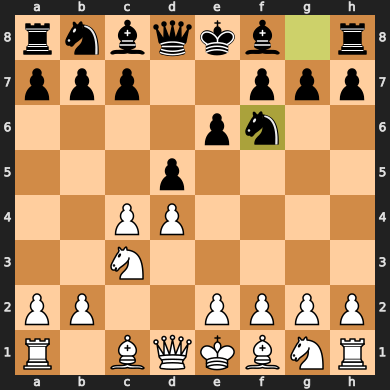

In [82]:
BOARD; svg2png(bytestring=BOARD._repr_svg_(), write_to='board.png')

In [21]:
def plot_count(count_df, by=None, bin_width=10, normalize_=False, **kwargs):
    plt.figure()
    
    count_df = count_df.transpose()
    
    stat = 'count'
    if normalize_:
        stat = 'frequency'
        for var in count_df.columns:
            sum_ = sum(count_df[var].values)
            count_df[var] = count_df[var] / sum_
        count_df = count_df.rename(columns={'count': 'frequency'})
        
    count_df['move'] = count_df.index
    melted_df = pd.melt(count_df, id_vars='move', var_name=by, value_name=stat)
    g = sns.catplot(x=by,
                    y=stat,
                    hue='move',
                    kind='bar',
                    legend=True,
                    data=melted_df,
                    **kwargs)
    return g

def plot_dist(move_df, by=None, bin_width=10, fmt_fn=True, **kwargs):
    fig, ax = plt.subplots()
    
    if by == 'year':
        move_df = move_df.copy()
        move_df['year'] = round_nearest(move_df['year'].values + (move_df['month'].values / 12).round(1), bin_width)
    
    g = sns.histplot(ax=ax,
                     x=by,
                     y=None,
                     hue='move',
                     binwidth=bin_width,
                     stat='frequency',
                     multiple='fill',
                     legend=True,
                     data=move_df,
                     **kwargs)
    if fmt_fn:
        g.get_xaxis().set_minor_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:g}'))
        g.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:g}'))
    return fig

def plot_violin(move_df, by=None, **kwargs):
    fig, ax = plt.subplots()
    _ = sns.violinplot(ax=ax,
                       x=by,
                       y='move',
                       data=move_df,
                       scale='count',
                       **kwargs)
    return fig

### Moves by ELO and year

In [37]:
def generate_report(move_df, var=None, bin_width=None, map_fn=None, dist_kwargs={}, violin_kwargs={}):
    df = top_moves_df.dropna(subset=[var])
    
    if var == 'year':
        map_fn = lambda df: df['year'] + (df['month']/12).round(1)
        bin_width = bin_width or 1
        violin_kwargs = {'cut': 0, 'bw': 0.95}
    elif var == 'avg_elo':
        map_fn = None
        bin_width = bin_width or 400
        dist_kwargs = {'binrange': (0, 3200)}
        violin_kwargs = {'cut': 1}
    else:
        raise ValueError(var)

    count_df = get_count_df(df, by=var, bin_width=bin_width, map_fn=map_fn)
    frequency_df = count_df.div(count_df.sum(axis=1), axis=0).round(3)

    count_plot = plot_count(count_df, by=var, bin_width=bin_width)
    distr_plot = plot_dist(move_df, by=var, bin_width=bin_width, **dist_kwargs)
    violin_plot = plot_violin(move_df, by=var, **violin_kwargs)
    
    return f"""
        <div style="display:block; width:800px;">
            <div><img src="board.png" /></div>
            <div style="display:flex">
                <div style="margin:auto;"><img src="data:image/png;base64,{encode_image(count_plot)}" /> </div>
                <div style="margin:auto;">{count_df.to_html()}</div>
            </div>
            <div style="display:flex">
                <div style="margin:auto;"><img src="data:image/png;base64,{encode_image(distr_plot)}" /> </div>
                <div style="margin:auto;">{frequency_df.to_html()}</div>
            </div>
            <div>
                <div><img src="data:image/png;base64,{encode_image(violin_plot)}"/></div>
            </div>
        </div>
    """


In [38]:
elo_report_html = generate_report(top_moves_df, var='avg_elo');
year_report_html = lambda x: x.split(' ')

/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


move,Bf4,Bg5,Nf3,cxd5,e3
avg_elo,,,,,
800,1.0,0.0,0.0,0.0,0.0
1200,0.0,15.0,2.0,7.0,0.0
1600,1.0,33.0,8.0,12.0,2.0
2000,1.0,81.0,19.0,56.0,6.0
2400,0.0,87.0,44.0,77.0,0.0
2800,1.0,0.0,1.0,1.0,0.0
move,Bf4,Bg5,Nf3,cxd5,e3
avg_elo,,,,,
800,1.000,0.000,0.000,0.000,0.000

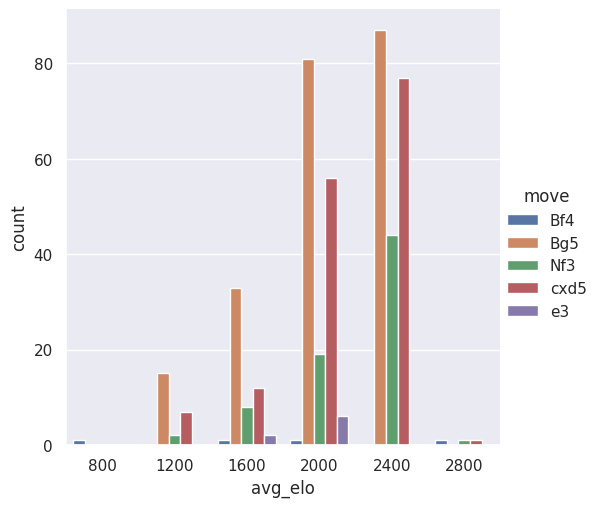
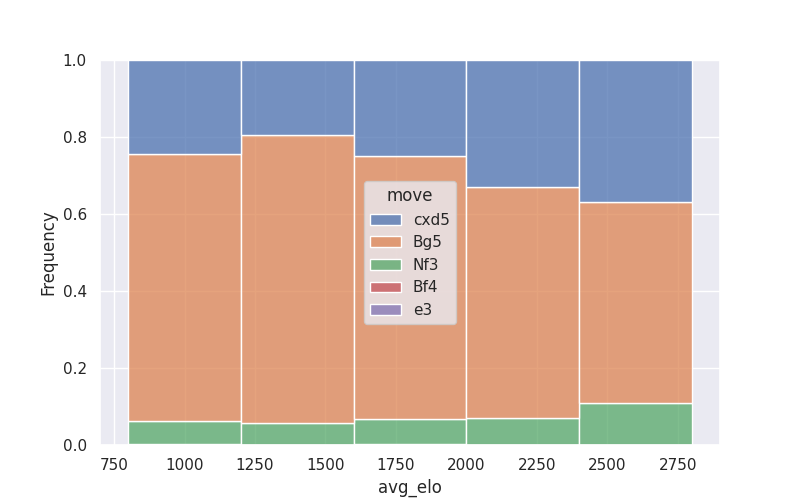
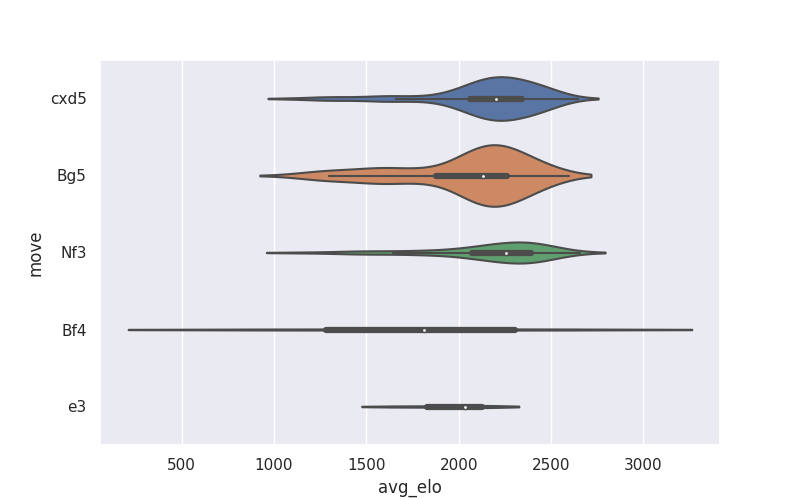

In [39]:
display(HTML(elo_report_html))

move,Bf4,Bg5,Nf3,cxd5,e3
year,,,,,
2000,4,78,17,37,5
2001,4,109,35,46,3
2002,1,89,25,41,4
2003,1,42,22,37,2
2004,1,32,11,22,2
move,Bf4,Bg5,Nf3,cxd5,e3
year,,,,,
2000,0.028,0.553,0.121,0.262,0.035
2001,0.020,0.553,0.178,0.234,0.015

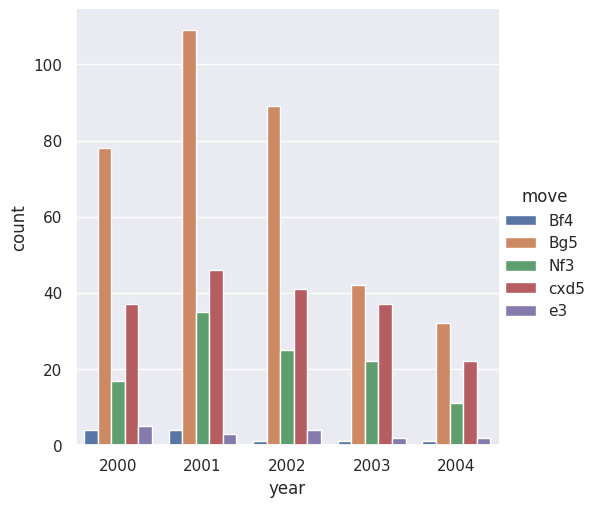
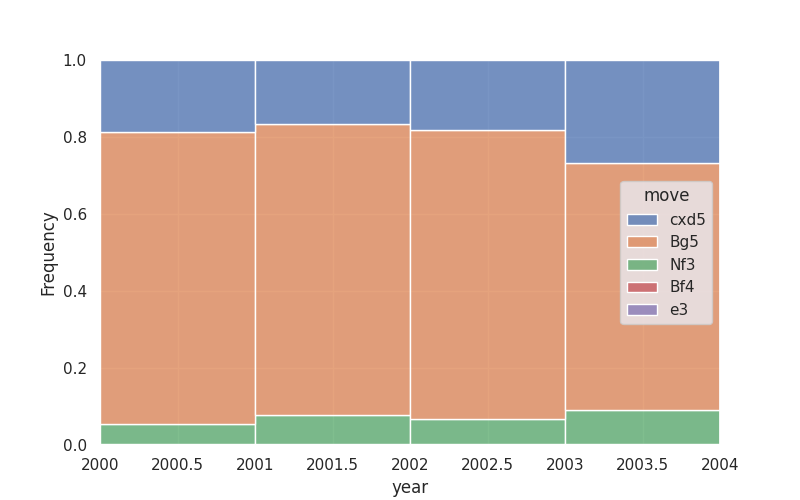
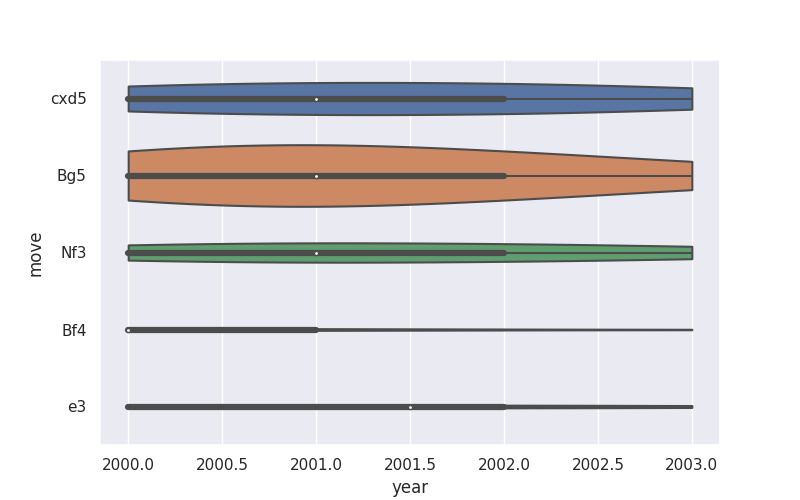

In [40]:
display(HTML(year_report_html))

## Analysis

### Get most commons lines from starting position

In [41]:
from collections import namedtuple

def get_top_lines(trie, max_depth=6):
    
    Line = namedtuple('Line', ['depth', 'score', 'moves', 'freqs'])
    
    move_df = build_move_df(trie)
    counts = move_df['move'].value_counts()
    frequencies = counts / len(move_df)
    
    lines = []
    for move, sub_trie in trie.items():
        
        if max_depth == 0 and move is not None:
            score = freq = frequencies[move]
            lines.append(Line(1, score, [move], [freq]))
        else:
            if isinstance(sub_trie, dict):
                top_sub_lines = get_top_lines(sub_trie, max_depth=max_depth-1)
                for _, score, sub_line, freqs in top_sub_lines:
                    freq = frequencies[move]
                    score = score * freq
                    lines.append(Line(len(sub_line)+1, score, [move] + sub_line, [freq] + freqs))
            elif move is None and isinstance(sub_trie, list):
                lines.append(Line(0, 1, [], []))
                
    return sorted(lines, reverse=True)

In [42]:
M = 20
D = 3

top_lines = get_top_lines(line_trie, max_depth=D)[:M]
top_lines_df = pd.DataFrame(line._asdict() for line in top_lines)

accum_prob = sum(l.score for l in top_lines)
print(f"{M} lines make up {accum_prob*100:.1f}% of the lines starting from {LINE}")
for line in top_lines:
    print(f"\t{np.round(line.score, 5)} {line.moves} {np.round(line.freqs, 3).tolist()}")

20 lines make up 67.7% of the lines starting from ['d4', 'd5', 'c4', 'e6', 'Nc3', 'Nf6']
	0.14032 ['cxd5', 'exd5', 'Bg5', 'Be7'] [0.27, 0.94, 0.948, 0.583]
	0.0901 ['Bg5', 'Be7', 'e3', 'O-O'] [0.517, 0.597, 0.579, 0.504]
	0.05022 ['cxd5', 'exd5', 'Bg5', 'c6'] [0.27, 0.94, 0.948, 0.209]
	0.04874 ['Bg5', 'Nbd7', 'e3', 'c6'] [0.517, 0.291, 0.5, 0.647]
	0.04136 ['cxd5', 'exd5', 'Bg5', 'Nbd7'] [0.27, 0.94, 0.948, 0.172]
	0.03102 ['Bg5', 'Be7', 'e3', 'Nbd7'] [0.517, 0.597, 0.579, 0.174]
	0.03102 ['Bg5', 'Be7', 'Nf3', 'Nbd7'] [0.517, 0.597, 0.297, 0.339]
	0.02954 ['Bg5', 'Be7', 'Nf3', 'O-O'] [0.517, 0.597, 0.297, 0.323]
	0.02806 ['Bg5', 'Nbd7', 'cxd5', 'exd5'] [0.517, 0.291, 0.186, 1.0]
	0.02659 ['Bg5', 'Be7', 'cxd5', 'exd5'] [0.517, 0.597, 0.1, 0.857]
	0.02511 ['Bg5', 'Nbd7', 'Nf3', 'c6'] [0.517, 0.291, 0.304, 0.548]
	0.02216 ['Bg5', 'Nbd7', 'e3', 'Be7'] [0.517, 0.291, 0.5, 0.294]
	0.02068 ['Bg5', 'Be7', 'e3', 'c6'] [0.517, 0.597, 0.579, 0.116]
	0.01625 ['Bg5', 'Be7', 'e3', 'h6'] [0.517, 0.5

In [28]:
#fen

In [98]:
df = top_moves_df.copy()
df = df.dropna(subset=['avg_elo'])
df[(round_nearest(df['avg_elo'], ELO_BIN_WIDTH) <= 1200) & (df['move'] == 'cxd5')]

,Event,Site,Date,Round,White,Black,Result,ECO,WhiteElo,moves,year,month,day,avg_elo,move,BlackElo
11,GER North-ch U12,Langeoog,2001.09.30,1.7,"Prum, Alexander","Scholz, Katharina",1/2-1/2,D35,1282,"[d4, d5, c4, e6, Nc3, Nf6, cxd5, exd5, Bg5, Be...",2001,9,30,1195.5,cxd5,1109
39,GER-ch U12,Willingen,2003.06.14,11,"Miclea, Sebastian Marius","Buechner, Felix",1-0,D36,1532,"[d4, d5, c4, e6, Nc3, Nf6, cxd5, exd5, Bg5, Be...",2003,6,14,1380.5,cxd5,1229
74,GER-ch U12,Winterberg,2002.05.21,6,"Gorodetski, Boris","Hirsch, Thomas",1-0,D35,1309,"[d4, d5, c4, e6, Nc3, Nf6, cxd5, exd5, Bg5, Be...",2002,5,21,1269.0,cxd5,1229
76,GER-ch U12,Willingen,2001.06.04,4,"Prum, Alexander","Bellinghausen, Helena",1/2-1/2,D35,1115,"[d4, d5, c4, e6, Nc3, Nf6, cxd5, exd5, Bg5, Be...",2001,6,4,1076.5,cxd5,1038
93,GER-ch U10,Willingen,2003.06.11,8,"Mohr, Fides","Wittke, Rene",0-1,D35,1161,"[d4, d5, c4, e6, Nc3, Nf6, cxd5, exd5, Bg5, Be...",2003,6,11,1299.5,cxd5,1438
173,AUS-ch U18,Canberra,2001.01.16,5.22,"Huynh, Arthur","Nagao, Daichi",1-0,D06,1480,"[d4, d5, c4, e6, Nc3, Nf6, cxd5, Nxd5, e4, Nf6...",2001,1,16,1339.5,cxd5,1199
174,Patras op,Patras,2002.08.05,6.36,"Holis, Hristos","Kaldiris, T.",1-0,D06,1625,"[d4, d5, c4, e6, Nc3, Nf6, cxd5, Nxd5, e4, Nf6...",2002,8,5,1312.5,cxd5,1000


In [109]:
az_games_gen = games_generator_from_file('alphazero_220.pgn', print_every=100)
az_trie = make_game_trie(az_games_gen)
print(count_trie(az_trie))

0
make_game_trie took 61.84s
220


In [111]:
count_trie(filter_trie(az_trie, white_moves={'a6'}))

32